# Parallelism scores

In [42]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
import scipy
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.decomposition import PCA


from cryptic_rnn import *

# Functions

In [43]:
def PS_score(u, v):
    return np.dot(u,v)/np.linalg.norm(u)/np.linalg.norm(v)


# Sequences

In [44]:
# RNN params
num_classes = 22
batchsize=1
hidden_size = 20

## sequences
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
primitives = generate_pos_primitives(all_syms, cue_dict)

trainseqs = generate_pos_other(ops, all_syms[:-1], cue_dict)
trainseqs_b = generate_pos_other(ops, all_syms[:-1], cue_dict) + generate_balanced_primitives(ops, all_syms, cue_dict)
trainseqs_p = trainseqs + primitives
trainseqs_bp = trainseqs_b + primitives

testseqs_all = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
testseqs = [seq for seq in testseqs_all if seq not in trainseqs_b]
val_idx = [idx for idx, seq in enumerate(testseqs_all) if seq not in trainseqs_b]

## read data 
save_dir = '../results/corrected/addition_trigrams_3inputs_bp_800'
with open(save_dir, 'rb') as f:
    res1 = pickle.load(f)


# Parallelism scores

In [45]:
full_rdmats = calculate_RDMs(res1, testseqs_all, subset = 'all')

no. 100% trained RNNs:  800


In [46]:
dms = full_rdmats['rdms']
dms_p = full_rdmats['rdms_p']
dms_b = full_rdmats['rdms_b']
dms_bp = full_rdmats['rdms_bp']
ft_cue_dicts =  full_rdmats['ft_cue_dicts']

matlist = [np.array(d).mean(axis = 0) for d in dms]
matlist_p = [np.array(d).mean(axis = 0) for d in dms_p]
matlist_b = [np.array(d).mean(axis = 0) for d in dms_b]
matlist_bp = [np.array(d).mean(axis = 0) for d in dms_bp]

In [55]:
xpair = pairs[1]

In [58]:
testseqs_all[4*xpair[1] + xpair[0]]

[('+', 'C'), ('+', 'A'), '=', 32]

In [66]:
mat = matlist_b[3]

In [68]:
pair_vecs

[array([-4.50381939, -4.53296894, -4.43589012, -1.48073952,  4.53296894,
         4.50855203,  4.50958007,  4.51035168, -2.98244916, -1.01800655,
        -2.29985084,  1.07555971,  4.4848663 ,  4.51068605,  4.49735503,
         4.51050406]),
 array([-1.43400574, -0.12378741, -1.47267018,  1.06942242,  1.32965355,
         1.41291629,  1.43124986,  1.43428789,  1.47267018,  1.43930434,
         1.43310692,  1.43423945,  1.44224783,  1.43638833,  1.43470679,
         1.43482367]),
 array([-11.24154801, -11.23773787, -11.24868167, -11.28306482,
         -5.27213205,  -3.59897009,  -4.6323524 ,  -0.20006605,
        -10.87585626,  -9.85787952, -10.42957982,  -7.42668532,
         11.28306482,  11.24282887,  11.23954259,  11.24078541]),
 array([ 3.06536424,  3.06548913,  3.05374838,  2.19684337, -2.4620975 ,
        -3.12124024, -3.16586022, -3.06746721,  3.06180286,  3.16586022,
         3.11681506,  0.75225195, -3.02868375, -3.05356404, -3.03922307,
        -3.06513409]),
 array([-6.74076

In [91]:
avps_p = []
for mat in dms_p[3]:
    pairs = list(itertools.combinations(np.arange(4),2))
    pair_vecs = []
    for xpair in pairs:
        pair_vecs.append(mat[:, 4*xpair[0] + xpair[1]] - mat[:, 4*xpair[1] + xpair[0]])

    pses = []
    ps_pairs = list(itertools.combinations(np.arange(len(pair_vecs)),2))
    pses = [PS_score(pair_vecs[psp[0]], pair_vecs[psp[1]]) for psp in ps_pairs]
    avps_p.append(np.mean(pses))

In [92]:
np.mean(avps_p)

0.2832011440942059

In [100]:
avps_b = []
for mat in dms_b[3]:
    pairs = list(itertools.combinations(np.arange(4),2))
    pair_vecs = []
    for xpair in pairs:
        pair_vecs.append(mat[:, 4*xpair[0] + xpair[1]] - mat[:, 4*xpair[1] + xpair[0]])

    pses = []
    ps_pairs = list(itertools.combinations(np.arange(len(pair_vecs)),2))
    pses = [PS_score(pair_vecs[psp[0]], pair_vecs[psp[1]]) for psp in ps_pairs]
    avps_b.append(np.mean(pses))

/var/folders/6y/z1h4y1t94jvb186qws4p3qq40000gn/T/ipykernel_17748/3277158792.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(u,v)/np.linalg.norm(u)/np.linalg.norm(v)


In [89]:
mat = matlist_b[3]
pairs = list(itertools.combinations(np.arange(4),2))
pair_vecs = []
for xpair in pairs:
    pair_vecs.append(mat[:, 4*xpair[0] + xpair[1]] - mat[:, 4*xpair[1] + xpair[0]])

pses = []
ps_pairs = list(itertools.combinations(np.arange(len(pair_vecs)),2))
pses = [PS_score(pair_vecs[psp[0]], pair_vecs[psp[1]]) for psp in ps_pairs]

In [90]:
np.mean(pses)

0.1026743913667965

In [83]:
pses

[0.6538753420578403,
 0.6195074913659915,
 -0.9490331219783168,
 0.29690646667484233,
 0.510818580941367,
 0.05695727781831558,
 -0.4163975917844035,
 -0.20336672438492237,
 -0.05352212891177557,
 -0.7408430895833293,
 0.9214535931623214,
 0.9888963292783935,
 -0.4498443268153226,
 -0.6567600649369902,
 0.9614678375979363]

In [80]:
pair_vecs[4]

array([-6.74076727, -6.74072477, -6.74265525, -6.74913029, -6.74039041,
       -6.76278465, -6.75222654, -6.81103922, -6.74055481, -6.73832338,
       -6.69988917, -6.57478219,  4.69376463,  6.81103922,  5.5524683 ,
        6.76269912])

In [79]:
PS_score(pair_vecs[4][0], pair_vecs[4][1])

1.0

In [47]:
mat = matlist_b[3]
pses = []
for k in range(4):
    print(testseqs_all[4*k+3],testseqs_all[4*k] )
    print(testseqs_all[12+k],testseqs_all[4*k] )
    u = mat[:, 4*k+3] - mat[:, 4*k] # B+D, B+A 
    v = mat[:, 12+k] - mat[:, 4*k] # D+B, A+B
    pses.append(PS_score(u,v))


[('+', 'A'), ('+', 'D'), '=', 17] [('+', 'A'), ('+', 'A'), '=', 30]
[('+', 'D'), ('+', 'A'), '=', 17] [('+', 'A'), ('+', 'A'), '=', 30]
[('+', 'B'), ('+', 'D'), '=', 7] [('+', 'B'), ('+', 'A'), '=', 20]
[('+', 'D'), ('+', 'B'), '=', 7] [('+', 'B'), ('+', 'A'), '=', 20]
[('+', 'C'), ('+', 'D'), '=', 19] [('+', 'C'), ('+', 'A'), '=', 32]
[('+', 'D'), ('+', 'C'), '=', 19] [('+', 'C'), ('+', 'A'), '=', 32]
[('+', 'D'), ('+', 'D'), '=', 4] [('+', 'D'), ('+', 'A'), '=', 17]
[('+', 'D'), ('+', 'D'), '=', 4] [('+', 'D'), ('+', 'A'), '=', 17]


In [48]:
pses

[0.6214811549658048, 0.8603200830847856, 0.859426329810719, 1.0]

In [50]:
mat = matlist_p[3]
pses = []
for k in range(4):
    print(testseqs_all[4*k+3],testseqs_all[4*k] )
    print(testseqs_all[12+k],testseqs_all[4*k] )
    u = mat[:, 4*k+3] - mat[:, 4*k] # B+D, B+A 
    v = mat[:, 12+k] - mat[:, 4*k] # D+B, A+B
    pses.append(PS_score(u,v))


[('+', 'A'), ('+', 'D'), '=', 17] [('+', 'A'), ('+', 'A'), '=', 30]
[('+', 'D'), ('+', 'A'), '=', 17] [('+', 'A'), ('+', 'A'), '=', 30]
[('+', 'B'), ('+', 'D'), '=', 7] [('+', 'B'), ('+', 'A'), '=', 20]
[('+', 'D'), ('+', 'B'), '=', 7] [('+', 'B'), ('+', 'A'), '=', 20]
[('+', 'C'), ('+', 'D'), '=', 19] [('+', 'C'), ('+', 'A'), '=', 32]
[('+', 'D'), ('+', 'C'), '=', 19] [('+', 'C'), ('+', 'A'), '=', 32]
[('+', 'D'), ('+', 'D'), '=', 4] [('+', 'D'), ('+', 'A'), '=', 17]
[('+', 'D'), ('+', 'D'), '=', 4] [('+', 'D'), ('+', 'A'), '=', 17]


In [51]:
pses

[0.9916851882161126,
 0.9916730985099546,
 0.9971161432806559,
 1.0000000000000002]

In [345]:
xpairs[3]

(1, 2)

In [346]:
s=2
xpairs = list(itertools.combinations(np.arange(4), 2))
for regime in [matlist_p, matlist_b, matlist_bp]:
    pses = []
    for x in xpairs:
        mline = regime[s][:,4*x[1]] - regime[s][:,4*x[0]]
        xline = regime[s][:,4*x[1]+x[0]] - regime[s][:, 4*x[0]+x[1]]
        pses.append(round(PS_score(mline, xline),2))
    print(pses)



[0.43, 0.54, 0.43, 0.52, 0.45, 0.39]
[0.9, 0.8, 0.88, 0.62, 0.89, 0.97]
[0.35, 0.66, 0.6, 0.54, 0.53, 0.54]


In [347]:
s = 2
N = len(dms[0])
ps_scores = []
ps_by_regime = []
for regime in [dms_p, dms_b, dms_bp]:
    scorelist = []
    for n in range(N):
        mline = regime[s][n][:,15] - regime[s][n][:,0]
        oppline = regime[s][n][:,12] - regime[s][n][:,3]
        ps_scores.append(PS_score(mline, oppline))
        scorelist += [PS_score(mline, oppline)]
    ps_by_regime.append(scorelist)
    

In [349]:
import scipy.stats as stats

#perform the Wilcoxon-Signed Rank Test
stats.wilcoxon(np.array(ps_by_regime[1]), np.array(ps_by_regime[2]))


WilcoxonResult(statistic=246787.0, pvalue=0.7046369369730574)

In [350]:
regimes = ['S_P']*N + ['B_NP']*N + ['B_P']*N
xpos = np.empty((0,1))
for i in range(3):
    xvals = np.ones(N)*i + np.random.normal(0, 0.05, N)
    xpos = np.append(xpos,xvals)

data = pd.DataFrame({'Regime':regimes, 'Scores': ps_scores})

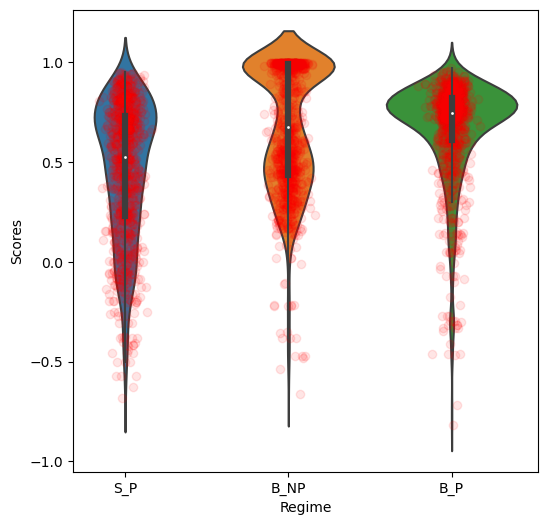

In [351]:
sns.violinplot(data, x="Regime", y="Scores")
plt.scatter(xpos, ps_scores, alpha=0.1, color='r')


In [356]:
np.mean(ps_by_regime[0])

0.4591041328799521

In [357]:
np.mean(ps_by_regime[1])

0.6722703341497445

In [358]:
np.mean(ps_by_regime[2])

0.6699917875394608

In [333]:
mline = dms[s][n][:,15] - dms[s][n][:,0]
oppline = dms[s][n][:,12] - dms[s][n][:,3]
print('S_NP PS: ', PS_score(mline, oppline))

mline = dms_p[s][n][:,15] - dms_p[s][n][:,0]
oppline = dms_p[s][n][:,12] - dms_p[s][n][:,3]
print('S_P PS: ', PS_score(mline, oppline))

mline = dms_b[s][n][:,15] - dms_b[s][n][:,0]
oppline = dms_b[s][n][:,12] - dms_b[s][n][:,3]
print('B_NP PS: ', PS_score(mline, oppline))

mline = dms_bp[s][n][:,15] - dms_bp[s][n][:,0]
oppline = dms_bp[s][n][:,12] - dms_bp[s][n][:,3]
print('B_P PS: ', PS_score(mline, oppline))



S_NP PS:  0.9844733645200326
S_P PS:  0.23381202762816383
B_NP PS:  0.9951798621254873
B_P PS:  0.7951756633520425


# With primitives

In [397]:
primseqs = testseqs_all + primitives

In [406]:
full_rdmats = calculate_RDMs_wprims(res1, primseqs, subset = 'all')

no. 100% trained RNNs:  1000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
2

In [14]:
prim_dms = full_rdmats['rdms']
prim_dms_p = full_rdmats['rdms_p']
prim_dms_b = full_rdmats['rdms_b']
prim_dms_bp = full_rdmats['rdms_bp']
ft_cue_dicts =  full_rdmats['ft_cue_dicts']

prim_matlist = [np.array(d).mean(axis = 0) for d in prim_dms]
prim_matlist_p = [np.array(d).mean(axis = 0) for d in prim_dms_p]
prim_matlist_b = [np.array(d).mean(axis = 0) for d in prim_dms_b]
prim_matlist_bp = [np.array(d).mean(axis = 0) for d in prim_dms_bp]

In [13]:
prim_matlist.shape

NameError: name 'prim_matlist' is not defined

In [ ]:
MDS_plot(prim_dms_p, primseqs, trainseqs, MDStype = 'MDS')

In [12]:
calculate_RDMs_wprims(res1, testseq, num_classes=22, batchsize=1,hidden_size=20, subset = 'all', h=1)

NameError: name 'testseq' is not defined

NameError: name 'primset' is not defined

In [430]:
colors1[17]

IndexError: list index out of range

In [404]:
def calculate_RDMs_wprims(res1, testseq, num_classes=22, batchsize=1,hidden_size=20, subset = 'all', h=1):
    
    acc_df = res1['acc_df']
    if subset == 'ft':
        all_acc_mods = acc_df[(acc_df['acc_train'] == 1) & (acc_df['acc_train_b'] == 1)&\
                              (acc_df['acc_train_bp'] == 1) & (acc_df['acc_train_p'] == 1)].index
    elif subset == 'all':
        all_acc_mods = acc_df.index
    print('no. 100% trained RNNs: ', len(all_acc_mods))
    mod_list = all_acc_mods # choose subset of rnns 

    rdms = [] # initialise empty lists/arrays
    rdms_p = []
    rdms_b = [] # initialise empty lists/arrays
    rdms_bp = []
    
    # extracts res1ults from dictionary
    mods = res1['mods']
    mods_p = res1['mods_p']
    mods_b = res1['mods_b']
    mods_bp = res1['mods_bp']

    cue_dicts = res1['cue_dicts']
    ft_cue_dicts = [cue_dicts[j] for j in mod_list]

    for ind, m in enumerate(mod_list): # for each model
        print(ind)

        testseqs = change_dict(testseq, cue_dicts[m])
        test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
        testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=False)

        # get activations for control model
        rmat = np.empty((0, len(testseq)))
        hiddens, trials = get_reps(mods[m], [testset], hidden_size)
        for hid in hiddens:
            if hid.shape[0] < 4:
                rmat = np.vstack([rmat, hid[h,:]])
            else:
                rmat = np.vstack([rmat, hid[h+2,:]])
        rdms.append(euclidean_distances(rmat))
        
        rmat = np.empty((0, len(testseq)))
        hiddens, trials = get_reps(mods_p[m], [testset], hidden_size)
        for hid in hiddens:
            if hid.shape[0] < 4:
                rmat = np.vstack([rmat, hid[h,:]])
            else:
                rmat = np.vstack([rmat, hid[h+2,:]])
        rdms_p.append(euclidean_distances(rmat))  

        rmat = np.empty((0, len(testseq)))
        hiddens, trials = get_reps(mods_b[m], [testset], hidden_size)
        for hid in hiddens:
            if hid.shape[0] < 4:
                rmat = np.vstack([rmat, hid[h,:]])
            else:
                rmat = np.vstack([rmat, hid[h+2,:]])
        rdms_b.append(euclidean_distances(rmat))  
 
        rmat = np.empty((0, len(testseq)))
        hiddens, trials = get_reps(mods_bp[m], [testset], hidden_size)
        for hid in hiddens:
            if hid.shape[0] < 4:
                rmat = np.vstack([rmat, hid[h,:]])
            else:
                rmat = np.vstack([rmat, hid[h+2,:]])
        rdms_bp.append(euclidean_distances(rmat))  

    return {'rdms': rdms, 'rdms_p': rdms_p, 'rdms_b': rdms_b, 'rdms_bp': rdms_bp, 'ft_cue_dicts': ft_cue_dicts}


In [ ]:
def MDS_plot(matlist, testseqs, trainseqs, MDStype = 'MDS', title = '', min_dim = 0, rand_state = 0):
    
    valset = [t for t in testseqs if t not in trainseqs]
    valset_idx = [testseqs.index(val) for val in valset]
    
    plt.rcParams['figure.figsize'] = 6, 6
    fig, axs = plt.subplots()
    for j, dist in enumerate(matlist):
        if MDStype == 'PCA':
            mds = PCA(n_components=3)
        if MDStype == 'MDS':
            mds = MDS(dissimilarity='precomputed',random_state=rand_state, n_components=3)

        X_transform = mds.fit_transform(dist)
        ax = axs
        for i in range(len(testseqs)):
            if i in valset_idx:
                alph = 1
            else:
                alph = 0.2
            ax.scatter(X_transform[i,min_dim], X_transform[i,min_dim+1], color = colors1[i], alpha = alph)
            ax.scatter(X_transform[i,min_dim], X_transform[i,min_dim+1], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)
    plt.suptitle('2D-MDS'+title)
    fig.legend(handles=legend_elements,  loc='center left', bbox_to_anchor=(1, 0.5)) 


In [432]:
colors2 = ['green', 'blue', 'orange', 'red']*4 + [ 'black']*4
colors1 = ['green']*4 + ['blue']*4 + ['orange']*4 + ['red']*4 + ['green', 'blue', 'orange', 'red']
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=5, label='A + _'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='B + _'), 
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=5, label='C + _'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5, label='D + _'),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'green', markerfacecolor='none', markersize=10, label=' _ + A'),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'blue',markerfacecolor='none', markersize=10, label=' _ + B'), 
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'orange',markerfacecolor='none', markersize=10, label=' _ + C'),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'red',markerfacecolor='none', markersize=10, label=' _ + D')]
